## Import the required libraries

In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Load the data

In [190]:
df = pd.read_csv(r"D:\Sahithi\sahithi\case study\stepstone\Lead_testdata.csv", delimiter=";")

### Data Analysis

In [191]:
df = df.fillna(0)
df["Target_Sales"].describe()

count     23245.000000
mean        811.380727
std        5722.474049
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      197848.000000
Name: Target_Sales, dtype: float64

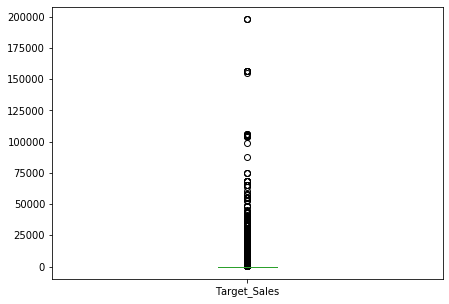

In [192]:
df[pd.notna(df["Target_Sales"])]["Target_Sales"].plot.box()
plt.rcParams["figure.figsize"] = (7, 5)

In [193]:
#(len(df[pd.notna(df["Target_Sales"])]["Target_Sales"]))
len(df["Target_Sales"]>92)

23245

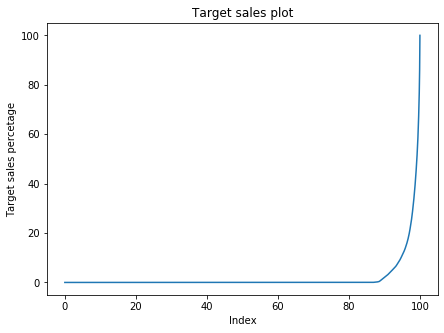

In [194]:
x=list(range(len(df["Target_Sales"])))
x_perc = [(_x / 23245 ) * 100 for _x in x] 
seriesCum = df["Target_Sales"].copy().sort_values().cumsum()/df["Target_Sales"].copy().sort_values().sum() * 100
plt.title("Target sales plot")
plt.ylabel("Target sales percetage")
plt.xlabel("Index")
plt.plot(x_perc,seriesCum)

There are a few high selling jobs and approximately 20% of the total sold jobs contribute to the maximum sales

### Classification Task : -	Predict the probability of sales success for a lead using the column “Target_Sold”.

In [195]:
X = df.drop(["ID","Target_Sold","Target_Sales"], 1)
y = df["Target_Sold"]

#### Using min-max scaling to tranform the data

In [196]:
scaler = MinMaxScaler()
scaler.fit(X)
X_transform = scaler.transform(X)
#pd.DataFrame(X_transform)

#### Dividing the data into train and test sets

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.33, random_state=42)

##### XGBoost Classifier

In [198]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_train, y_train)
y_pred_prob = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)
confusionMatrix = confusion_matrix(y_test, y_pred)
print(confusionMatrix)
print("Accuracy score: ", accuracy_score(y_test, y_pred) * 100)

[[6503  137]
 [ 355  676]]
Accuracy score:  93.58623386781385


In [199]:
pd.DataFrame(y_pred_prob).describe()

,0,1
count,7671.000000,7671.000000
mean,0.863573,0.136427
std,0.248749,0.248749
min,0.013634,0.000460
25%,0.881463,0.002767
50%,0.978281,0.021719
75%,0.997233,0.118537
max,0.999540,0.986366


#### Probability of sales success for a lead

In [200]:
pd.DataFrame(y_pred_prob[:,1])

,0
0,0.001328
1,0.009171
2,0.050838
3,0.333415
4,0.045359
5,0.925403
6,0.007889
7,0.002435
8,0.008928
9,0.014304


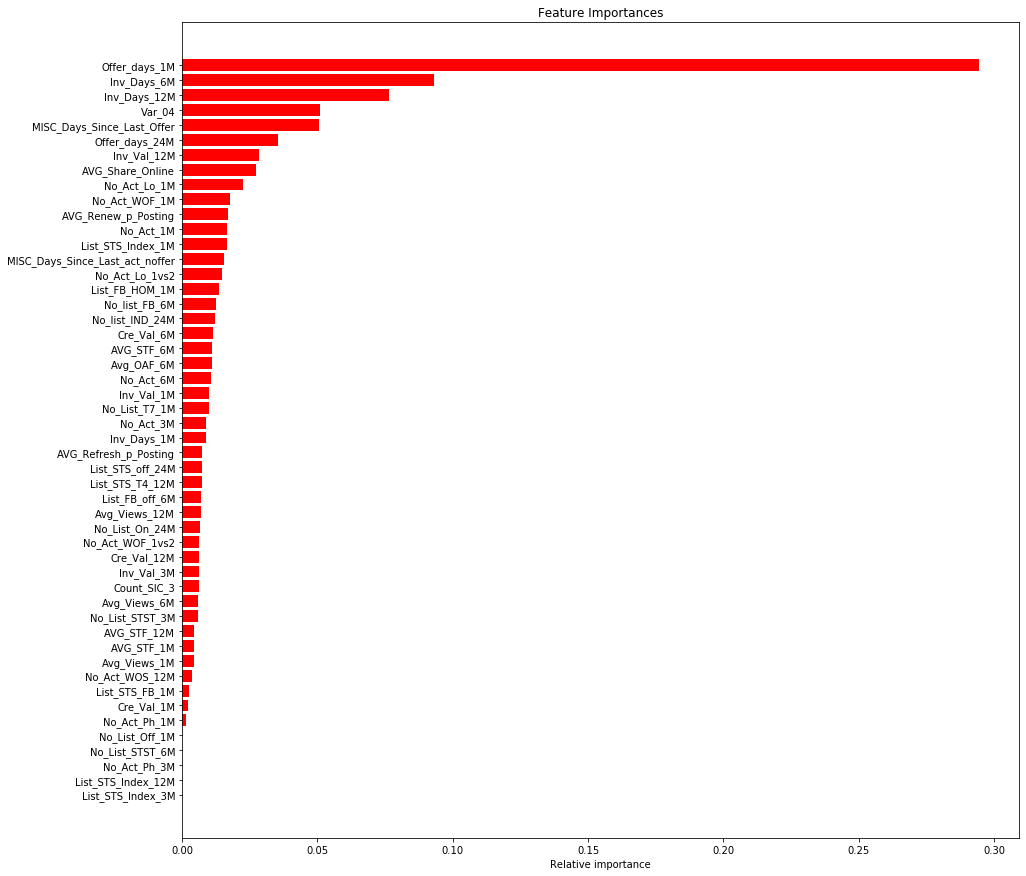

In [219]:
indices = np.argsort(xgb_model.feature_importances_)
#Plotting the feature importances
plt.title("Feature Importances")
plt.barh(range(len(indices)), xgb_model.feature_importances_[indices], color='r', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative importance")
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()

### Regression task: -	Predict the contract value of successful sales using the column “Target_Sales”.

#### Filtering only the successful sales data

In [201]:
df_sold = df[df["Target_Sold"]==1]

In [202]:
F = df_sold.drop(["ID", "Target_Sales", "Target_Sold"], 1)  #feature matrix
t = df_sold["Target_Sales"]                  # target matrix

#### Using min-max scaling 

In [203]:
scaler = MinMaxScaler()
scaler.fit(F)
F_transform = scaler.transform(F)

#### Dividing the data into train and test sets

In [204]:
F_train, F_test, t_train, t_test = train_test_split(F_transform, t, test_size=0.33, random_state=42)

#### XGBoost regressor

In [205]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(F_train,t_train)
t_pred = xgb_reg.predict(F_test)
pd.DataFrame(t_pred).describe()

C:\Users\SAkela\AppData\Local\Continuum\anaconda3\envs\sahithi_ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:03:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,0
count,1033.000000
mean,6113.238770
std,13459.708984
min,105.390015
25%,1744.479126
50%,2297.073975
75%,4887.184082
max,188203.765625


#### Contract value of successful sales 

In [206]:
pd.DataFrame(t_pred)

,0
0,1889.558594
1,1866.153442
2,1346.942017
3,5426.824707
4,2719.353760
5,10471.319336
6,2322.955322
7,1713.481934
8,21981.263672
9,17311.943359


In [207]:
mse = metrics.mean_squared_error(t_test,t_pred)
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

Root mean squared error:  6526.525979263707


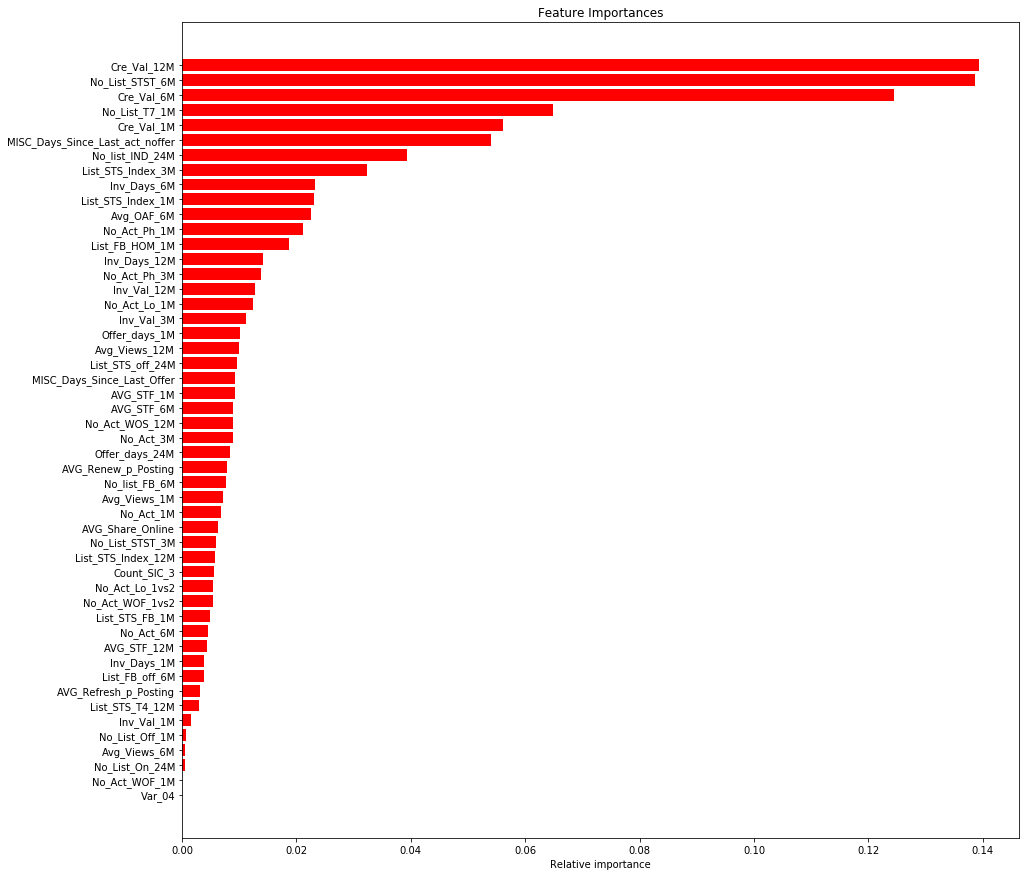

In [218]:
indices = np.argsort(xgb_reg.feature_importances_)
#Plotting the feature importances
plt.title("Feature Importances")
plt.barh(range(len(indices)), xgb_reg.feature_importances_[indices], color='r', align='center')
plt.yticks(range(len(indices)), [F.columns[i] for i in indices])
plt.xlabel("Relative importance")
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()

In [209]:
t_pred_proba = xgb_model.predict_proba(F_test)
t_pred_proba_success = t_pred_proba[:,1]

### Calcution of the potential

In [210]:
potential = np.multiply(t_pred, t_pred_proba[:,1])

In [211]:
potential_df = pd.DataFrame(potential)
potential_df.describe()

,0
count,1033.000000
mean,3004.135010
std,7717.743164
min,3.260160
25%,598.759338
50%,1405.677856
75%,2190.129150
max,149471.390625


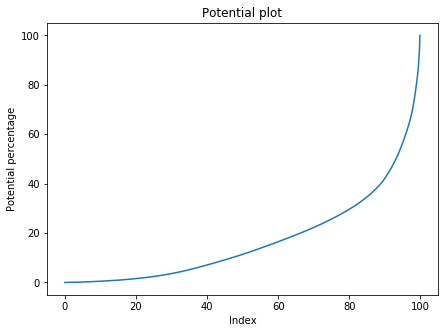

In [216]:
i=list(range(len(potential_df)))
i_perc = [(_i / len(potential_df)) * 100 for _i in i]
seriesCum = potential_df.copy().sort_values(by=0).cumsum()/potential_df.copy().sort_values(by=0).sum() * 100
plt.title("Potential plot")
plt.ylabel("Potential percentage")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (7, 5)
plt.plot(i_perc,seriesCum)

In [213]:
potential_df.nlargest(round(len(potential)*0.4), 0)

,0
139,149471.390625
425,73848.382812
516,73848.382812
884,73848.382812
176,45917.171875
848,45917.171875
997,45333.296875
419,34317.011719
394,33820.835938
463,33820.835938


###### The potential mean of model is approximately four times higher than the mean of target_sales of the actual data. This means we can forward the high and low probable leads with high sales and can leave the less potential ones, as the last 40% of the leads contribute the maximum sales